In [1]:
# google_play_scraperのインストール
!pip install google_play_scraper

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [7]:
# ライブラリの読み込み
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

In [9]:
# google_play_scraperでレビュー取得
from google_play_scraper import Sort, reviews_all

# 「Uber - Request a ride - Google Play」からレビューを取得する
jp_reviews = reviews_all(
    'com.ubercab.driver',
    sleep_milliseconds=0,  # defaults to 0
    lang='ja',  # defaults to 'en'
    country='jp',  # defaults to 'us'
    sort=Sort.NEWEST,  # defaults to Sort.MOST_RELEVANT
)

In [10]:
# 取得したレビューをデータフレームに格納
df_bush = pd.DataFrame(np.array(jp_reviews), columns=['review'])
df_bush = df_bush.join(pd.DataFrame(df_bush.pop('review').tolist()))

## 01.月別スコアの集計


### 運用開始日から現在までのスコア推移を棒グラフで表示

In [30]:
df = df_bush[['at', 'score', 'content']]
print(df.shape)
df.to_csv("Uber_Driver.csv", index=False,escapechar='\\')

(1574, 3)


In [12]:
df['score'].value_counts()  # ユニーク値（score）のカウント

1    977
2    197
5    161
3    160
4     79
Name: score, dtype: int64

In [15]:
# 月別でスコア数を表示
df_score = df[['at', 'score']]

# crosstableでscoreを横軸に変換
df_score = pd.crosstab(df['at'], df['score'], dropna=False)

# resampleで月毎に
df_score = df_score.resample('M').sum()

# 月別スコア データフレームを作成
df_score

score,1,2,3,4,5
at,,,,,
2015-02-28,0,0,1,0,0
2015-03-31,0,0,0,0,0
2015-04-30,0,0,0,0,0
2015-05-31,0,0,0,0,0
2015-06-30,0,0,0,0,0
...,...,...,...,...,...
2023-07-31,17,9,4,1,4
2023-08-31,19,4,7,0,2
2023-09-30,11,5,2,1,2


<AxesSubplot: xlabel='at'>

<Figure size 432x288 with 0 Axes>

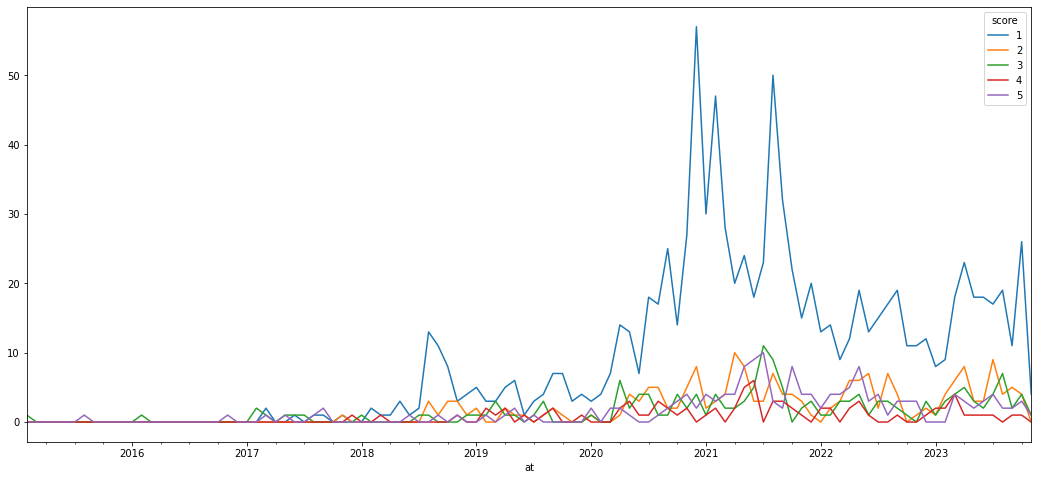

In [16]:
# plotで折れ線グラフを表示
plt.figure()
df_score.plot(figsize=(18,8))

リリース当初
- 高評価が目立つものの、低評価（1~2）も無視できない様子

現在（11月）
- 低評価の方が目立つようになる

### 100%積み上げ棒グラフで年別スコアを集計

In [17]:
# 100%積み上げグラフで表示
# 月別で集計
df_score_month = df_score.resample('Y').sum()
df_score_month

score,1,2,3,4,5
at,,,,,
2015-12-31,0,0,1,0,1
2016-12-31,0,0,1,0,1
2017-12-31,6,1,6,1,5
2018-12-31,49,11,4,2,3
2019-12-31,51,10,11,10,5
2020-12-31,206,36,29,15,19
2021-12-31,329,52,47,25,63
2022-12-31,165,40,25,12,40
2023-12-31,171,47,36,14,24


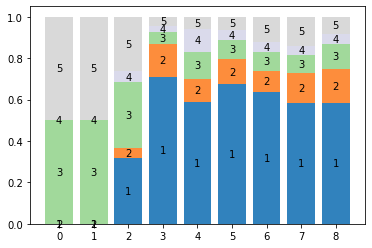

In [18]:
# 100%積み上げグラフ
# 正規化する
df_score_month2 = df_score_month.div(df_score_month.sum(axis=1), axis=0)

n_rows, n_cols = df_score_month2.shape
positions = np.arange(n_rows)
offsets = np.zeros(n_rows, dtype=df_score_month2.values.dtype)
colors = plt.get_cmap("tab20c")(np.linspace(0, 1, n_cols))

fig, ax = plt.subplots()
ax.set_xticks(positions)

for i in range(len(df_score_month2.columns)):
    # 棒グラフを描画する。
    bar = ax.bar(positions, df_score_month2.iloc[:, i], bottom=offsets, color=colors[i])
    offsets += df_score_month2.iloc[:, i]

    # 棒グラフのラベルを描画する。
    for rect in bar:
        cx = rect.get_x() + rect.get_width() / 2
        cy = rect.get_y() + rect.get_height() / 2
        ax.text(cx, cy, df_score_month2.columns[i], color="k", ha="center", va="center")


まだ折れ線グラフ・棒グラフの可視化から、リリースしてから３ヶ月足らずだが、評価が減少傾向にあることがわかった。

### 直近1カ月間のスコア推移とレビューの表示

In [19]:
# 2023年度のスコア推移とレビューの表示
date_start = "2023-01-01"

df_score_ex = df_score[date_start:]
df_score_ex

score,1,2,3,4,5
at,,,,,
2023-01-31,8,1,1,2,0
2023-02-28,9,4,3,2,0
2023-03-31,18,6,4,4,4
2023-04-30,23,8,5,1,3
2023-05-31,18,3,3,1,2
2023-06-30,18,3,2,1,3
2023-07-31,17,9,4,1,4
2023-08-31,19,4,7,0,2
2023-09-30,11,5,2,1,2


<AxesSubplot: xlabel='at'>

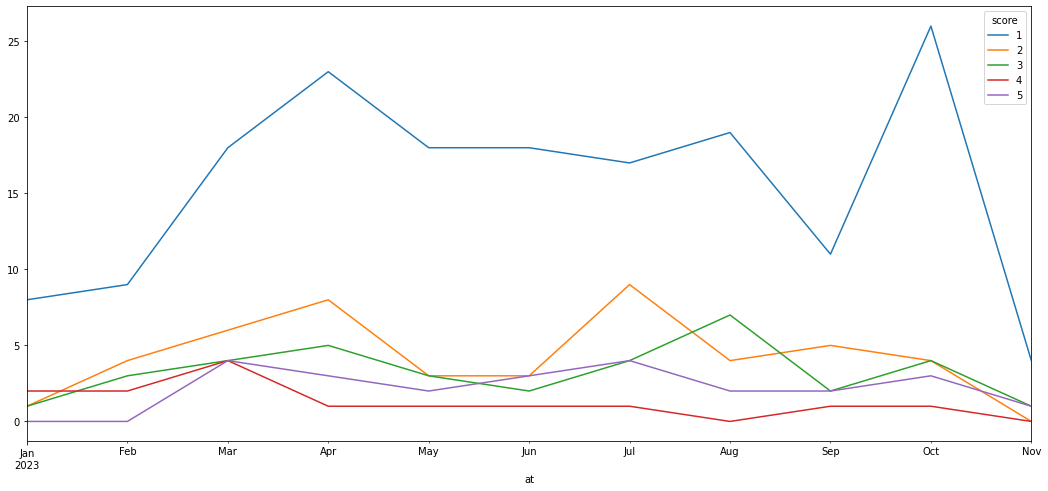

In [20]:
# グラフの表示
df_score_ex.plot(figsize=(18,8))

## 02.テキストマイニング（形態素解析

In [21]:
# 直近1カ月のレビューをデータフレーム化
df1 = df_bush[['at','content']]
df1 = df[(df['at'] > dt.datetime(2023,10,1)) & (df['at'] < dt.datetime(2023,10,31))]

テキストのみ抽出

In [22]:
df1 = df1[['content']]
df1 = df1.rename(columns={'content': 'text'})

MeCabで形態素解析を行う

In [23]:
#インストール
!pip install mecab-python3

#辞書インストール
!pip install unidic-lite

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and wil

In [24]:
# MeCabで形態素解析を行う
import MeCab

def mecab_text(text):

    #MeCabのインスタンスを作成（辞書はmecab-ipadic-neologdを使用）
    mecab = MeCab.Tagger('-Owakati')

    #形態素解析
    node = mecab.parseToNode(text)

    #形態素解析した結果を格納するリスト
    wordlist = []

    while node:
        #名詞のみリストに格納する
        if node.feature.split(',')[0] == '名詞':
            wordlist.append(node.surface)
        #形容詞を取得、elifで追加する
        elif node.feature.split(',')[0] == '形容詞':
            wordlist.append(node.surface)
        #動詞を取得、elifで追加する
        #elif node.feature.split(',')[0] == '動詞':
        #    wordlist.append(node.surface)
        node = node.next
    return wordlist

# 形態素結果をリスト化し、データフレームdf1に結果を列追加する
df1['words'] = df1['text'].apply(mecab_text)

# 表示
df1


,text,words
9,頻繁な写真確認ヘルメットの写真撮ったあとに 顔の写真確認撮れは意味分からん,"[写真, 確認, ヘルメット, 写真, あと, 顔, 写真, 確認, 意味]"
10,全体的に説明が分かりにくい 日本語で書いてあるが説明が足らないというか、ヘルプを参照するのも...,"[全体, 説明, 日本, 語, 説明, ヘルプ, 参照, UBER, 外国, 企業, せい,..."
11,ゴミです。 最初の置き配注文で商品を撮影する時に、カメラを起動してから誤って戻るボタンを押し...,"[ゴミ, 最初, 配, 注文, 商品, 撮影, 時, カメラ, 起動, ボタン, カメラ, ..."
12,最悪アプリ,"[最悪, アプリ]"
13,自分は持病の都合でウーバーの様な仕事を選択するしかないが、何故こうも配達員が多いのか理解に苦...,"[自分, 持病, 都合, バー, 仕事, 選択, ない, 配達, 多い, 理解, 3, 年,..."
14,地図か見ずらい案内が遠回り前と違って了解が走行中押しづらい,"[地図, 案内, 遠回り, 前, 了解, 走行]"
15,ブースト無くなってから単価マシになってきた！この調子で頼む！やはりクエスト抜きで平均400円...,"[ブースト, 単価, 調子, クエスト, 抜き, 平均, 400, 円, 死守, 欲しい, ..."
16,たまに勝手にオンラインになったり 落ちたりします,"[勝手, オン, ライン]"
17,2023/10/25頭の悪いアップデートでお客に見せる現金表示が安っぽくなった。何かを変えな...,"[2023, 10, 25, 悪い, アップデート, 客, 現金, 表示, 安っぽく, 仕事..."
18,バイク優遇しすぎ 今から自転車稼働されたい方はやめたほうがいいですよ。,"[バイク, 優遇, 今, 自転, 稼働, 方, ほう, いい]"


In [25]:
pip install nlplot

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
# nlplotで直近1カ月のレビューを可視化・分析
# 頻出単語
import nlplot

npt = nlplot.NLPlot(df1, target_col='words')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定
stopwords = npt.get_stopword(top_n=0, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    stopwords=stopwords,
)


100%|██████████| 35/35 [00:00<00:00, 89024.04it/s]


In [27]:
npt.word_distribution(
    title='number of words distribution',
    xaxis_label='count',
)

In [28]:
# 単語数の分布
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
    stopwords=stopwords,
)

100%|██████████| 35/35 [00:00<00:00, 109798.53it/s]


In [29]:
# ワードクラウド
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)